## Import Libraries

In [1]:
# Numeric Libaries
import numpy as np

# Mediapipe Libaries
import mediapipe as mp

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model

# Scikit Learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

# Plot Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Camera Libaries
import cv2

# Other Libraries
import os

## Declare Mediapipe Variables

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

In [3]:
# Draw and Set Landmark
def draw_landmarks(img, res):
    # Render Left Hand Connections
    mp_drawing.draw_landmarks(img, res.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                            mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                            mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                            ) 
    # Render Right Hand Connections
    mp_drawing.draw_landmarks(img, res.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                            )
    # Draw face connections
    mp_drawing.draw_landmarks(img, res.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(img, res.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 

def mediapipe_detection(img, model):
    # Set Flags Writeable False, to optimze the detection process
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img.flags.writeable = False
        
    # Holistic model return landmarks
    results = model.process(img)

    # Draw Detection on the footage/image
    img.flags.writeable = True
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
    return img, results

## Dataset Collections

In [4]:
def generate_keypoints(results):
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)    
    return np.concatenate([left_hand, right_hand, pose, face])

In [5]:
# Check Label Folder (Create if not exists)
def create_folder_label(dataset_dir, label, sequence_length):
        
    for sequence_num in range(sequence_length):
        try:
            os.makedirs(os.path.join(dataset_dir, label, str(sequence_num)))
        except:
            pass

In [6]:
def collect_dataset(dataset_dir, label_name, sequence_length, frame_length):
    create_folder_label(dataset_dir, label_name, sequence_length)
    cap = cv2.VideoCapture(0)
    # Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence=0.4, min_tracking_confidence=0.4) as holistic:
        # Loop through sequences aka videos
        for sequence in range(0, sequence_length):
            # Loop through video length aka sequence length
            for frame_num in range(frame_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_landmarks(image, results)

                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(label_name, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(100)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(label_name, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)

                # NEW Export keypoints
                keypoints = generate_keypoints(results)
                npy_path = os.path.join(dataset_dir, label_name, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()

## Declare Some Variables

In [7]:
dataset_dir = os.path.join("phrases_dataset_collections")
sequence_length = 30
frame_length = 30

## Main

In [8]:
def main():
    label_name = input("Enter Label Name:")
    collect_dataset(dataset_dir, label_name, sequence_length, frame_length)

In [38]:
if __name__ == "__main__":
    main()

Enter Label Name:Thank You


## Processing Data

In [9]:
def fast_scandir(dirname):
    labels = []
    for root, dirs, _ in os.walk(dirname):
        labels = dirs
        break
    return labels

In [10]:
actions = fast_scandir(dataset_dir)
actions = np.array(actions)
label_map = {label:num for num, label in enumerate(actions)}

In [11]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(dataset_dir, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(dataset_dir, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [24]:
X = np.array(sequences)
Y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

# Create LSTM Model For ASL Phrases

In [25]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

### Train Model

In [26]:
model.fit(X_train, y_train, epochs=2000)

Epoch 1/2000
2/2 [==============================] - 3s 59ms/step - loss: 0.6949 - categorical_accuracy: 0.5000
Epoch 2/2000
2/2 [==============================] - 0s 60ms/step - loss: 0.6951 - categorical_accuracy: 0.5000
Epoch 3/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.5299 - categorical_accuracy: 0.8542
Epoch 4/2000
2/2 [==============================] - 0s 41ms/step - loss: 1.2807 - categorical_accuracy: 0.5208
Epoch 5/2000
2/2 [==============================] - 0s 37ms/step - loss: 1.8798 - categorical_accuracy: 0.5208
Epoch 6/2000
2/2 [==============================] - 0s 49ms/step - loss: 0.8046 - categorical_accuracy: 0.6458
Epoch 7/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.5962 - categorical_accuracy: 0.7917
Epoch 8/2000
2/2 [==============================] - 0s 37ms/step - loss: 1.5493 - categorical_accuracy: 0.5208
Epoch 9/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.8566 - categorical_accuracy: 0.5000
E

2/2 [==============================] - 0s 41ms/step - loss: 2.4835e-09 - categorical_accuracy: 1.0000
Epoch 74/2000
2/2 [==============================] - 0s 41ms/step - loss: 2.4835e-09 - categorical_accuracy: 1.0000
Epoch 75/2000
2/2 [==============================] - 0s 47ms/step - loss: 2.4835e-09 - categorical_accuracy: 1.0000
Epoch 76/2000
2/2 [==============================] - 0s 40ms/step - loss: 2.4835e-09 - categorical_accuracy: 1.0000
Epoch 77/2000
2/2 [==============================] - 0s 42ms/step - loss: 2.4835e-09 - categorical_accuracy: 1.0000
Epoch 78/2000
2/2 [==============================] - 0s 42ms/step - loss: 2.4835e-09 - categorical_accuracy: 1.0000
Epoch 79/2000
2/2 [==============================] - 0s 53ms/step - loss: 2.4835e-09 - categorical_accuracy: 1.0000
Epoch 80/2000
2/2 [==============================] - 0s 62ms/step - loss: 2.4835e-09 - categorical_accuracy: 1.0000
Epoch 81/2000
2/2 [==============================] - 0s 40ms/step - loss: 2.4835e-09 -

2/2 [==============================] - 0s 37ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 144/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 145/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 146/2000
2/2 [==============================] - 0s 45ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 147/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 148/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 149/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 150/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 151/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.00

2/2 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 214/2000
2/2 [==============================] - 0s 50ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 215/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 216/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 217/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 218/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 219/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 220/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 221/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.00

2/2 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 284/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 285/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 286/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 287/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 288/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 289/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 290/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 291/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.00

KeyboardInterrupt: 

### Save Model

In [36]:
model_path = os.path.join("model_collections", "PhrasesModel")
model.save(model_path)
np.save(os.path.join(model_path, "known_labels"), actions)

INFO:tensorflow:Assets written to: model_collections\PhrasesModel\assets


INFO:tensorflow:Assets written to: model_collections\PhrasesModel\assets


### Evaluate Model

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 32)            216960    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           82432     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 355,106
Trainable params: 355,106
Non-tr

#### Confusion Matrix

In [28]:
yhat = model.predict(X_test)

In [29]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [30]:
yhat_labels = []
ytrue_labels = []

In [31]:
for i in range(0,len(yhat)):
    yhat_labels.append(actions[yhat[i]])
    ytrue_labels.append(actions[ytrue[i]])

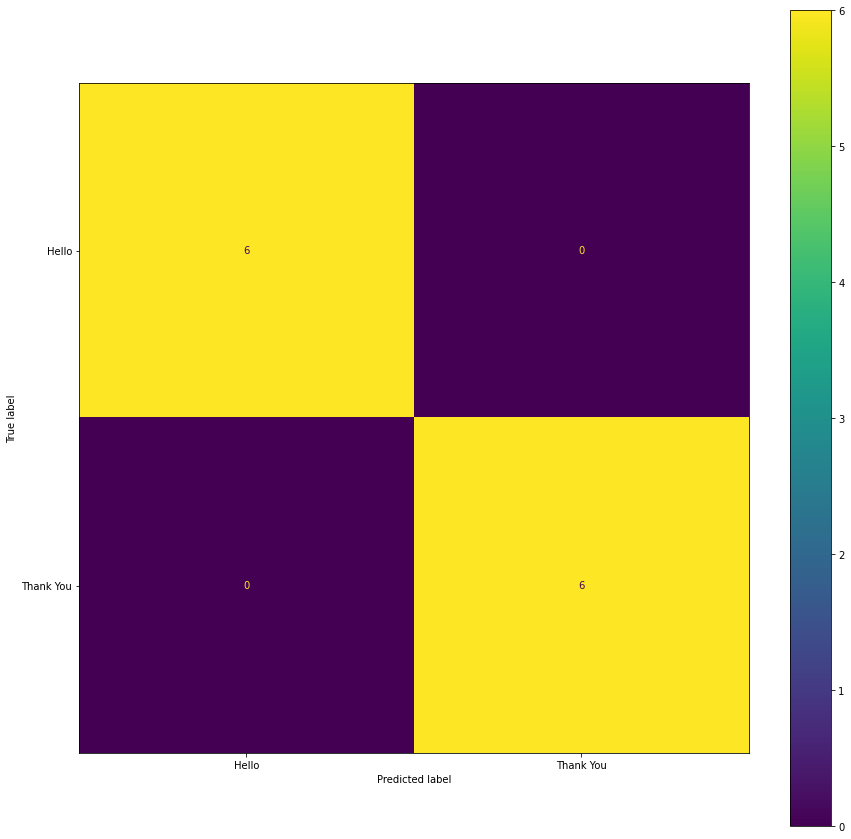

In [32]:
cm = confusion_matrix(ytrue_labels, yhat_labels, labels=np.unique(ytrue_labels))
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(ytrue_labels))
fig, ax = plt.subplots(figsize=(15,15))
cmd.plot(ax=ax)

#### Accuracy Score

In [33]:
accuracy_score(ytrue, yhat)

1.0

## Realtime Test

In [35]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.98

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.4, min_tracking_confidence=0.4) as holistic:
    while cap.isOpened():

        # Read feed
        success, frame = cap.read()
        if not success:
            print("There is no camera feeds!")
            continue

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = generate_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-20:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
Thank You
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Thank You
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Thank You
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Thank You
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Thank You
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Thank You
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Thank You
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Thank You
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Thank You
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Thank You
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Thank You
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Thank You
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Thank You
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Thank You
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Thank